In [1]:
import re

import pandas as pd
import numpy as np

import acquire
import prepare

import helpers.nlp

In [2]:
def wrangle_prepped_data():
    # Get unprepped data
    df = acquire.wrangle_data()
    # Keep languages that appear more than 10 times
    lang_to_keep = df.language.value_counts()[df.language.value_counts() > 10].index
    df = df[df.language.isin(lang_to_keep)]
    # Drop remaining nulls
    df = df.dropna()

    # Remove markdown links and html code
    links = re.compile(r'(\(http.+\))')
    html = re.compile(r'(<.*?>)')
    df.readme_contents = df.readme_contents.replace(html, '')
    df.readme_contents = df.readme_contents.replace(links, '')

    # Create some NLP columns
    df['cleaned'] = df.readme_contents.apply(helpers.nlp.sanitize, 
                                            # Reduce noise by removing these words as well as common stopwords
                                            extra_words=['&#9;', "'", 'nbsp', '1','2'])
    # Lemmatize instead of stem
    df['lemm_readme'] = df.cleaned.apply(helpers.nlp.lemmatize)
    # Get some bigrams
    df['bigrams'] = df.lemm_readme.apply(helpers.nlp.make_ngrams, n=2)

    return df

In [3]:
df = wrangle_prepped_data()

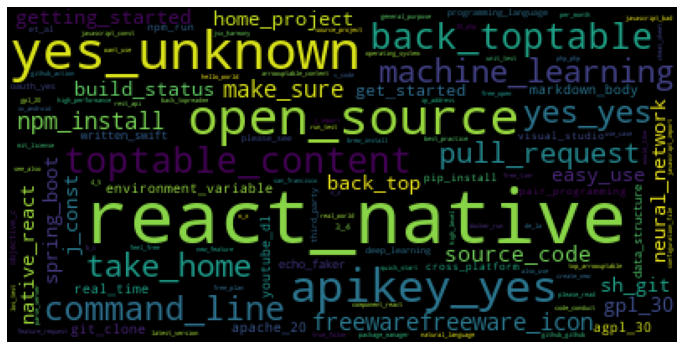

In [4]:
import helpers.viz

helpers.viz.plot_wordcloud(df.bigrams)

In [5]:
from wordcloud import WordCloud

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os


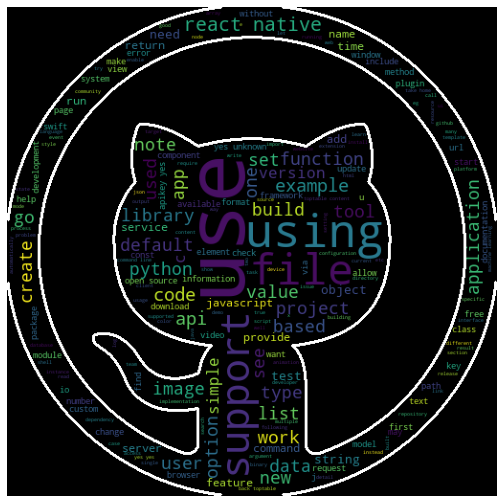

In [7]:
mask = np.array(Image.open('./img/github-white.png'))
wc = WordCloud(background_color='black', mask= mask, contour_width=2, contour_color='white')

wc.generate(' '.join(df.lemm_readme))
plt.figure(figsize=[9,9])
plt.imshow(wc)
plt.axis("off")
# plt.draw()
# plt.savefig('./img/git_icon_cloud.png', bbox_inches='tight',dpi=600)
plt.show()

In [8]:
vc = helpers.nlp.get_word_freq(df.lemm_readme)
vc

use          4902
file         4234
react        3614
code         3362
using        3350
             ... 
maggie          1
crompton        1
morrissey       1
furmann         1
exermote        1
Length: 102173, dtype: int64

<AxesSubplot:>

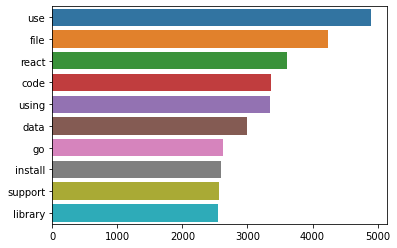

In [9]:
import seaborn as sns
temp = vc.head(10)
sns.barplot(x= temp, y=temp.index)

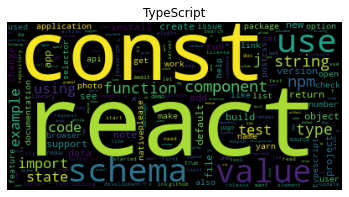

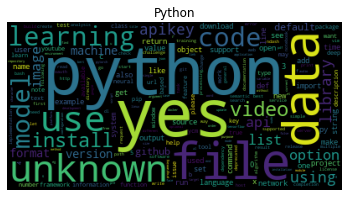

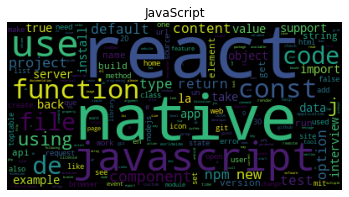

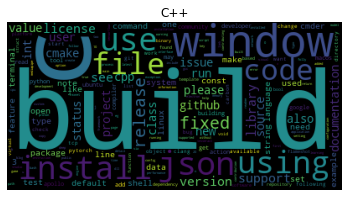

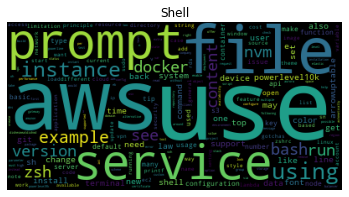

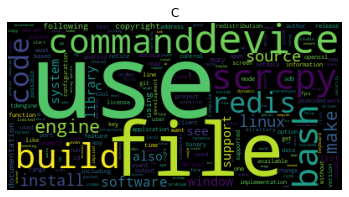

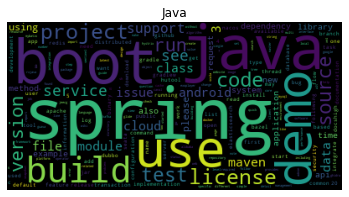

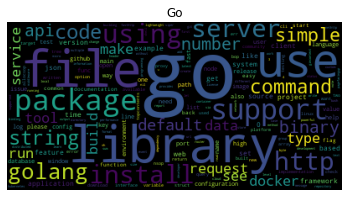

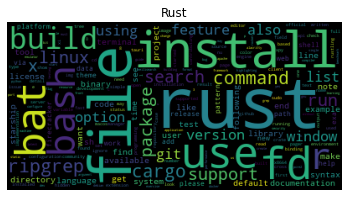

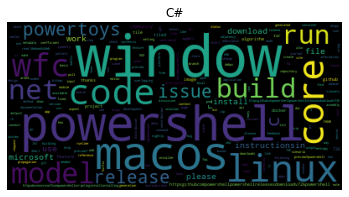

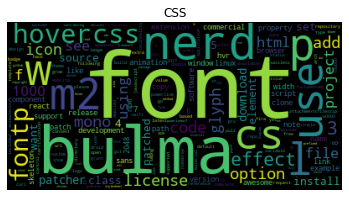

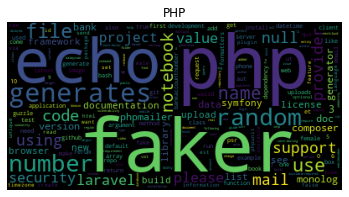

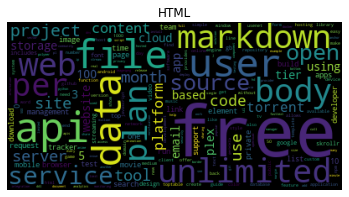

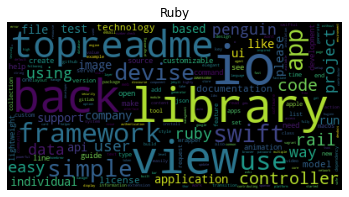

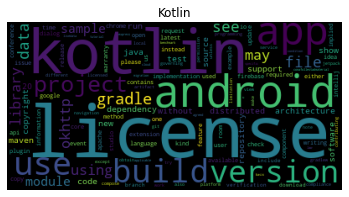

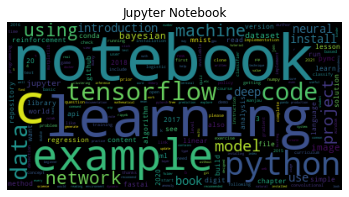

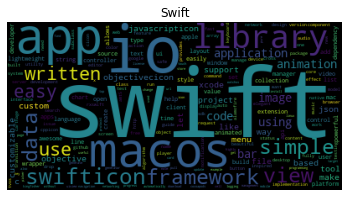

In [10]:
for cat in df.language.unique().tolist():
    helpers.viz.plot_wordcloud(df[df.language == cat].lemm_readme, title=cat, figsize=[6,5])

In [18]:
langs_not_self_mention = [  
                        'Shell',
                        'HTML',
                        'CSS',
                        ]


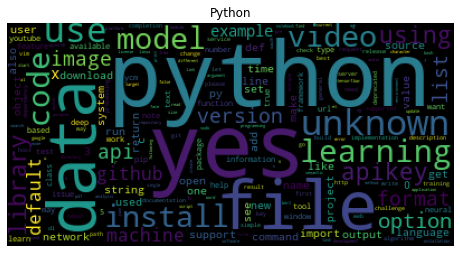

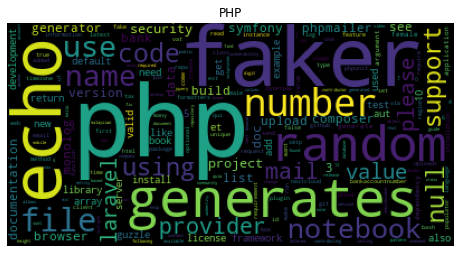

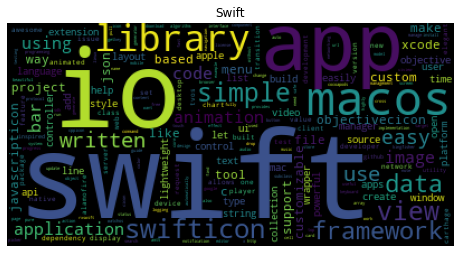

In [17]:
langs_self_mention = [  
                        'Python',
                        'PHP',
                        'Swift',
                        ]
for cat in langs_self_mention:
    helpers.viz.plot_wordcloud(df[df.language == cat].lemm_readme, title=cat, figsize=[8,6], save_path=f'./img/{cat}_cloud.png')

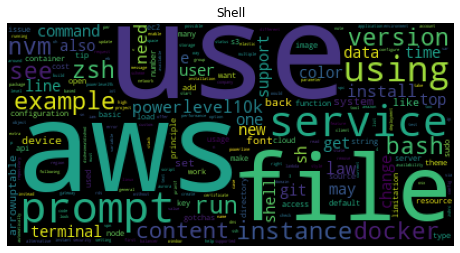

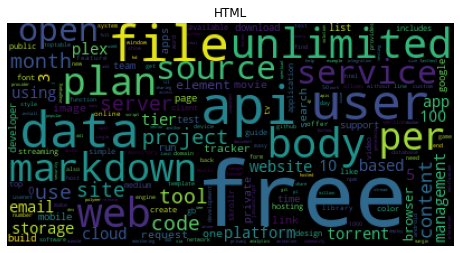

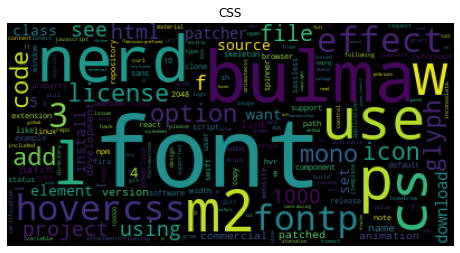

In [20]:
for cat in langs_not_self_mention:
    helpers.viz.plot_wordcloud(df[df.language == cat].lemm_readme, title=cat, figsize=[8,6], save_path=f'./img/{cat}_cloud.png')

In [14]:
# %pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [15]:
from textblob import TextBlob
df['polarity'] = df.lemm_readme.apply(lambda x: TextBlob (x).sentiment.polarity)
df.head()

,repo,language,readme_contents,cleaned,lemm_readme,bigrams,polarity
0,freeCodeCamp/freeCodeCamp,TypeScript,[![freeCodeCamp Social Banner]\n\n[![Pull Requ...,freecodecamp social banner pull requests welco...,freecodecamp social banner pull request welcom...,freecodecamp_social social_banner banner_pull ...,0.181037
4,kamranahmedse/developer-roadmap,TypeScript,\n \n roadmap.sh\n Community driven roadmap...,roadmapsh community driven roadmaps articles r...,roadmapsh community driven roadmaps article re...,roadmapsh_community community_driven driven_ro...,0.107879
5,public-apis/public-apis,Python,\n Public APIs\n A collective list of fr...,public apis collective list free apis use soft...,public apis collective list free apis use soft...,public_apis apis_collective collective_list li...,-0.027127
6,vuejs/vue,TypeScript,\n\n\n \n \n \n \n \n \n\n\n## This repo...,repo vue looking repository vue repo vue 3 vue...,repo vue looking repository vue repo vue 3 vue...,repo_vue vue_looking looking_repository reposi...,0.194270
7,facebook/react,JavaScript,# [React]\n\nReact is a JavaScript library for...,react react javascript library building user i...,react react javascript library building user i...,react_react react_javascript javascript_librar...,0.201707


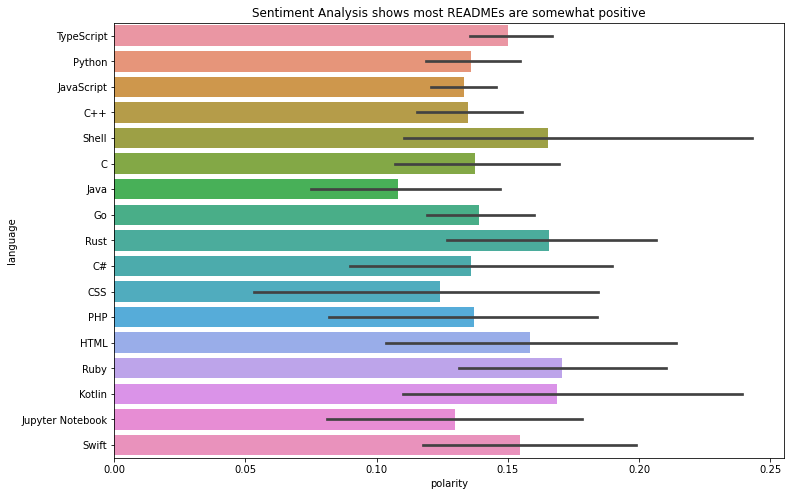

In [21]:
plt.figure(figsize=[12,8])
sns.barplot(data=df, y='language', x='polarity')
plt.title('Sentiment Analysis shows most READMEs are somewhat positive')
plt.savefig('./img/sentiment_by_language.png')
plt.show()